# Bi-level Locality Sensitive Hashing for K-Nearest Neighbor Computation

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import cauchy
from sklearn.metrics import euclidean_distances
import scipy.stats as stats
import scipy.spatial.distance as dis
import math
from sklearn.preprocessing import Normalizer
import sys
from hashlib import md5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mbyte = 1048576

norm_l1 = Normalizer(norm='l1')
norm_l2 = Normalizer(norm='l2')
std_scaler = StandardScaler()

## tools

In [2]:
def generate_md5(H):
    hmd5 = md5()
    hmd5.update(str(H).encode(encoding='utf-8'))
    return hmd5.hexdigest()

## Metrics

In [917]:
# metrics
def metrics(candidates, approximate_neighbors, exact_neighbors, q, P):
    # recall
    recall = recall_ratio(candidates, exact_neighbors)
    # error
    error = error_ratio(q, exact_neighbors, approximate_neighbors, P) 
    # selectivity
    s = selectivity(candidates, P)
    return recall, error, s

# recall ratio
def recall_ratio(candidates, exact_neighbors):
    return len(np.intersect1d(candidates, exact_neighbors)) / len(exact_neighbors)

# error ratio
def error_ratio(v, exact_neighbors, approximate_neighbors, P):
    k = len(approximate_neighbors)
    exact = np.array([dis.euclidean(v, P[idx]) for idx in exact_neighbors])[:k]
    approximate = np.array([dis.euclidean(v, P[idx]) for idx in approximate_neighbors])
    return np.sum(exact / approximate) / k

# selectivety
def selectivity(candidates, P):
    return len(candidates) / len(P)

In [900]:
metric_results = dict()

## datasets

In [4]:
%store -r k_near_neighbors
%store -r test_n

In [5]:
dataset_title = 'SIFT-10K'

In [6]:
%store -r train_sift
%store -r test_sift

## Random Projection

In [484]:
P = datasets.make_blobs(centers=1, n_features=2, n_samples=10000, random_state=1, cluster_std=5)[0]

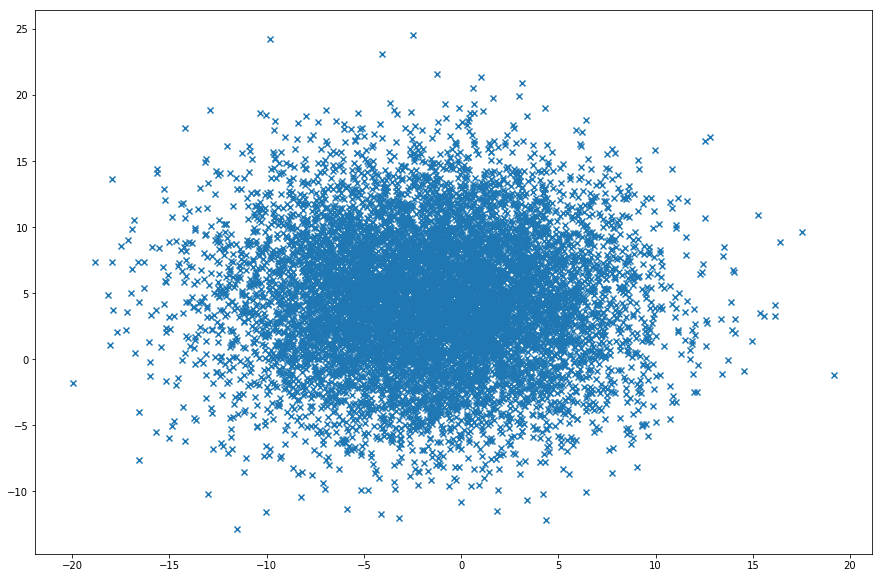

In [1111]:
plt.figure(figsize=(15, 10))
plt.scatter(P[:, 0], P[:, 1], marker='x')
plt.show()

### Compute Diameter

In [486]:
def compute_diamter(P, n=40):
    idxs = np.arange(len(P))
    
    idx = np.random.randint(len(P))
    p = P[idx]
    q1_idx = find_farthest(P, p)
    q1 = P[q1_idx]
    q2_idx = find_farthest(P, q1)
    q2 = P[q2_idx]
    rho = dis.euclidean(p, q1)
    r = dis.euclidean(q1, q2)
    r_arr = [r]
    
    for i in range(1, n):
        if p in P:
            np.delete(P, idx)
        if q1 in P:
            np.delete(P, q1_idx)
        if len(P) <= 1:
            break

        p1 = q1 + (r / rho) * (p - q1)
        p = 0.5 * (p1 + q1)
        q1_idx = find_farthest(P, p)
        q1 = P[q1_idx]
        q2_idx = find_farthest(P, q1)
        q2 = P[q2_idx]
        rho = dis.euclidean(p, q1)
        r = dis.euclidean(q1, q2)

        if r <= r_arr[i - 1]:
            return r_arr

        r_arr.append(r)

    return r_arr

In [487]:
def find_farthest(P, q):
    return np.argsort(np.array([dis.euclidean(p, q) for p in P]))[-1]

In [488]:
%%time
euclidean_distances(P).max()

CPU times: user 2.13 s, sys: 305 ms, total: 2.44 s
Wall time: 1.75 s


39.98574512515246

In [489]:
%%time
compute_diamter(P)

CPU times: user 650 ms, sys: 9.77 ms, total: 660 ms
Wall time: 557 ms


[39.985745125152455]

In [490]:
idxs = np.arange(len(P))
v = P[np.random.choice(idxs, 2, replace=False)]
v = v[1]- v[0]

projection = P.dot(v)
mid = np.median(projection)

idxs_R = np.argwhere(projection >= mid)
idxs_L = np.argwhere(projection < mid)
R = idxs[np.concatenate(idxs_R)]
L = idxs[np.concatenate(idxs_L)]

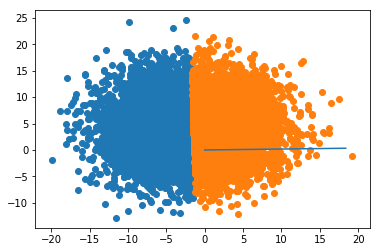

In [491]:
plt.plot([0, v[0]], [0, v[1]])
plt.scatter(P[L, 0], P[L, 1])
plt.scatter(P[R, 0], P[R, 1])
plt.show()

### Normal

In [741]:
def rp_forest_normal(P, n_trees=10, max_depth=None, min_size=None, random_state=None):
    """
    Desc:
        Only support the leafs arg.
    
    Args:
        n_trees: number of trees
        max_depth: default(None)
        random_state
    
    Returns:
        forest
        
    """
    assert max_depth is not None or min_size is not None, \
        "Should give one of the value of max_depth and min_size"

    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)
    
    forest = []
    n, d = P.shape
    s_idxs = [] # stack of current index of points
                # idxs, parent_node, direction, depth

    for i in range(n_trees): # build forest
        tree = dict()
        s_idxs.append((np.arange(n), tree, 'root', 0, '')) # root node

        while len(s_idxs) != 0:
            idxs, parent_node, direc, depth, code = s_idxs.pop()

            node = dict()

            if depth >= max_depth:
                node['idxs'] = idxs
                parent_node[direc] = node
                node['code'] = int(code, 2)
                continue

            v = idxs[rand.choice(np.arange(len(idxs)), 2, replace=False)] # choose two points randomly
            v = P[v[1]]- P[v[0]]
            
            projection = P[idxs].dot(v)
            mid = np.median(projection)
            
            node['v'] = v
            node['split'] = mid

            idxs_R = np.argwhere(projection >= mid)
            idxs_L = np.argwhere(projection < mid)

            if len(idxs_R) == 0 or len(idxs_L) == 0: # 划分失败
                continue
            
            parent_node[direc] = node
            
            R = idxs[np.concatenate(idxs_R)]
            L = idxs[np.concatenate(idxs_L)]

            s_idxs.append((R, node, 'r', depth + 1, code + '0'))
            s_idxs.append((L, node, 'l', depth + 1, code + '1'))
            
        forest.append(tree)
        
    return forest

#### Build Tree

In [1122]:
%%time
forest = rp_forest_normal(P, max_depth=8, random_state=0)

CPU times: user 1.56 s, sys: 36.6 ms, total: 1.59 s
Wall time: 803 ms


random projection tree (mean)


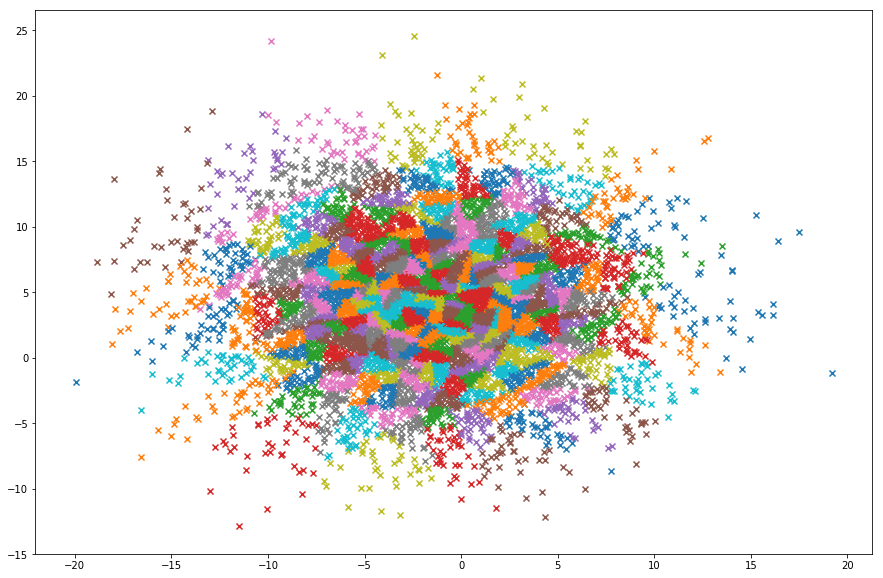

In [1123]:
print('random projection tree (mean)')
tree = forest[0]
plt.figure(figsize=(15, 10))
stack = [tree['root']]
while len(stack) != 0:
    node = stack.pop()
    if 'idxs' not in node:
        stack.append(node['r'])
        stack.append(node['l'])
    else:
        plt.scatter(P[node['idxs'], 0], P[node['idxs'], 1], marker='x', alpha=1)

plt.show()

#### Search

In [752]:
def search_tree_normal(tree, q):
    node = tree['root']
    while 'idxs' not in node:
        projection = q.dot(node['v'])
        if projection >= node['split']:
            node = node['r']
        else:
            node = node['l']
    return node['code']

In [839]:
def search_leaf_normal(tree, q):
    node = tree['root']
    while 'idxs' not in node:
        projection = q.dot(node['v'])
        if projection >= node['split']:
            node = node['r']
        else:
            node = node['l']
    return node['idxs']

In [757]:
search_tree_normal(forest[0], P[0])

9

In [ ]:
def find_nearest_neighbors_normal(forest, q):
    candidates = []
    for tree in forest:
        candidates.append(search_tree_normal(tree, q))
    if len(candidates) != 0:
        candidates = np.unique(np.concatenate(np.array(candidates)))
    
    return candidates

### Mean

In [745]:
def rp_forest_mean(P, n_trees=10, c=4, max_depth=None, min_size=None, random_state=None):
    """
    Desc:
        Now only support the leafs arg.
    
    Args:
        n_trees: number of trees
        depth:
        random_state
    
    Returns:
        split
        forest
        forest_leafs
        
    """
    assert max_depth is not None or min_size is not None, \
        "Should give one of the value of max_depth or min_size"

    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)

    forest = []
    n, d = P.shape
    V = dict()
    s_idxs = []

    for i in range(n_trees):
        tree = dict()
        s_idxs.append((np.arange(n), tree, 'root', 0, ''))

        while len(s_idxs) != 0:
            idxs, parent_node, direc, depth, code = s_idxs.pop()

            node = dict()

            if depth >= max_depth:
                node['idxs'] = idxs
                parent_node[direc] = node
                node['code'] = int(code, 2)
                continue
                
            v = idxs[rand.choice(np.arange(len(idxs)), 2, replace=False)]
            v = P[v[1]]- P[v[0]]
            node['v'] = v
            
            diameter = compute_diamter(P[idxs])[-1]

            mean_P = P[idxs].mean(axis=0)
            dis_P = np.array([dis.euclidean(mean_P, p) for p in P[idxs]])
            avg_2_diameter = 2 * np.sum(dis_P ** 2) / len(idxs)
#             diameters = []
#             select_idxs = idxs[rand.choice(np.arange(len(idxs)), 40, replace=False)]
#             for idx in select_idxs:
#                 diameters.append(np.array([dis.euclidean(P[idx], p) for p in P[idxs]]).max())
#             avg_diameters = np.array(diameters).mean()
#             avg_2_diameters = avg_diameters ** 2
            
            diameter_2 = diameter ** 2
            # print(diameter_2, avg_2_diameter)

            node['mean'] = mean_P
            
            if diameter_2 <= c * avg_2_diameter:
                projection = P[idxs].dot(v)
                split = np.median(projection)
                node['split'] = split
                node['type'] = 0
            else:
                projection = dis_P
                split = np.median(projection)
                node['split'] = split
                node['type'] = 1

            idxs_R = np.argwhere(projection > split)
            idxs_L = np.argwhere(projection <= split)

            # print(len(idxs_R), len(idxs_L))
            
            if len(idxs_R) != 0:
                R = idxs[np.concatenate(idxs_R)]
            if len(idxs_L) != 0:
                L = idxs[np.concatenate(idxs_L)]
            
            parent_node[direc] = node
            
            # print(direc)
            s_idxs.append((R, node, 'r', depth + 1, code + '0'))
            s_idxs.append((L, node, 'l', depth + 1, code + '1'))
            
        forest.append(tree)

    return forest

#### Build Tree

In [746]:
%%time
forest = rp_forest_mean(P, c=4, max_depth=4, random_state=1)

CPU times: user 34.8 s, sys: 10.1 ms, total: 34.8 s
Wall time: 34.9 s


random projection tree (mean)


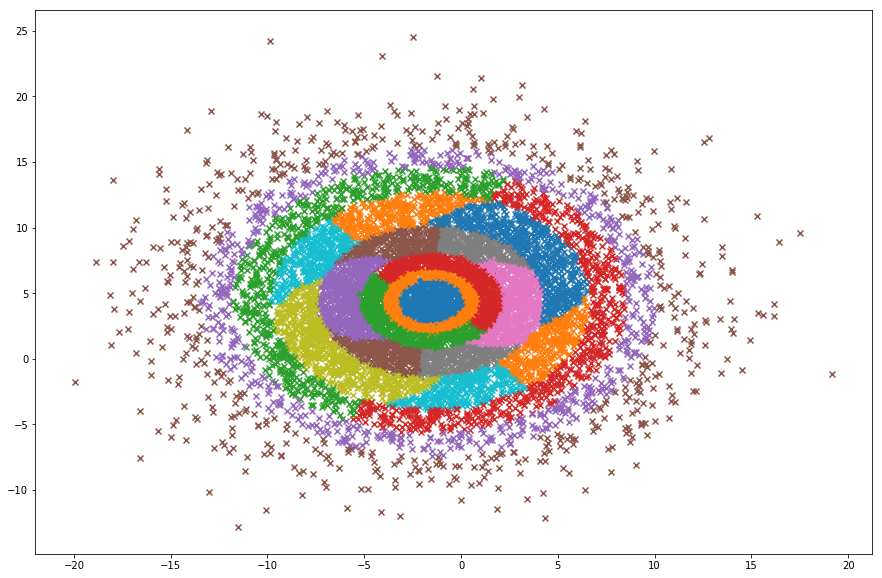

In [747]:
print('random projection tree (mean)')
tree = forest[0]
plt.figure(figsize=(15, 10))
stack = [tree['root']]
while len(stack) != 0:
    node = stack.pop()
    if 'idxs' not in node:
        stack.append(node['r'])
        stack.append(node['l'])
    else:
        plt.scatter(P[node['idxs'], 0], P[node['idxs'], 1], marker='x', alpha=1)

plt.show()

In [ ]:
def search_tree_mean(tree, q):
    node = tree['root']
    while 'idxs' not in node:
        if node['type'] == 1:
            projection = np.sqrt(np.sum((q - node['mean']) ** 2)) 
        else:
            projection = q.dot(node['v'])

        if projection > node['split']:
            node = node['r']
        else:
            node = node['l']
    return node['idxs']

In [ ]:
def find_nearest_neighbors_mean(forest, q):
    candidates = []
    for tree in forest:
        candidates.append(search_tree_mean(tree, q))
    if len(candidates) != 0:
        candidates = np.unique(np.concatenate(np.array(candidates)))
    
    return candidates

#### Search

In [ ]:
%%time
q_idx = np.random.randint(10000)
print('find P[{}] nearest neighbors'.format(q_idx))
q = P[q_idx]
# candidates = search_tree(forest[0], q)
candidates = find_nearest_neighbors_mean(forest, q)
print('number of candidates: {}'.format(len(candidates)))
plt.figure(figsize=(15, 10))
plt.scatter(P[:, 0], P[:, 1])
plt.scatter(P[candidates, 0], P[candidates, 1])
plt.scatter(q[0], q[1], c='r')
plt.show()

### Max

#### Build Tree

In [748]:
def rp_forest_max(P, n_trees=10, max_depth=None, min_size=None, random_state=None):
    """
    Desc:
        Now only support the leafs arg.
    
    Args:
        n_trees: number of trees
        depth:
        random_state
    
    Returns:
        split
        forest
        forest_leafs
        
    """
    assert max_depth is not None or min_size is not None, \
        "Should give one of the value of max_depth or min_size"

    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)
    
    
    forest = []
    n, d = P.shape
    s_idxs = []

    for i in range(n_trees):
        tree = dict()
        s_idxs.append((np.arange(n), tree, 'root', 0, ''))

        while len(s_idxs) != 0:
            idxs, parent_node, direc, depth, code = s_idxs.pop()

            node = dict()

            if depth >= max_depth:
                node['idxs'] = idxs
                parent_node[direc] = node
                node['code'] = int(code, 2)
                continue

            v = idxs[rand.choice(np.arange(len(idxs)), 2, replace=False)]
            v = P[v[1]]- P[v[0]]
            node['v'] = v

            x = P[idxs[rand.randint(len(idxs))]]
            diameter = np.array([dis.euclidean(x, p) for p in P[idxs]]).max()
            delta = (rand.rand() * 2 - 1) * diameter / np.sqrt(d)
            
            projection = P[idxs].dot(v)

            split = np.median(projection) + delta

            node['split'] = split            

            idxs_R = np.argwhere(projection > split)
            idxs_L = np.argwhere(projection <= split)

            if len(idxs_R) != 0:
                R = idxs[np.concatenate(idxs_R)]
            if len(idxs_L) != 0:
                L = idxs[np.concatenate(idxs_L)]
            
            parent_node[direc] = node

            s_idxs.append((R, node, 'r', depth + 1, code + '0'))
            s_idxs.append((L, node, 'l', depth + 1, code + '1'))
            
        forest.append(tree)
        
    return forest

In [749]:
%%time
forest = rp_forest_max(P, max_depth=4, random_state=1)

CPU times: user 11 s, sys: 379 ms, total: 11.4 s
Wall time: 6.74 s


random projection tree (mean)


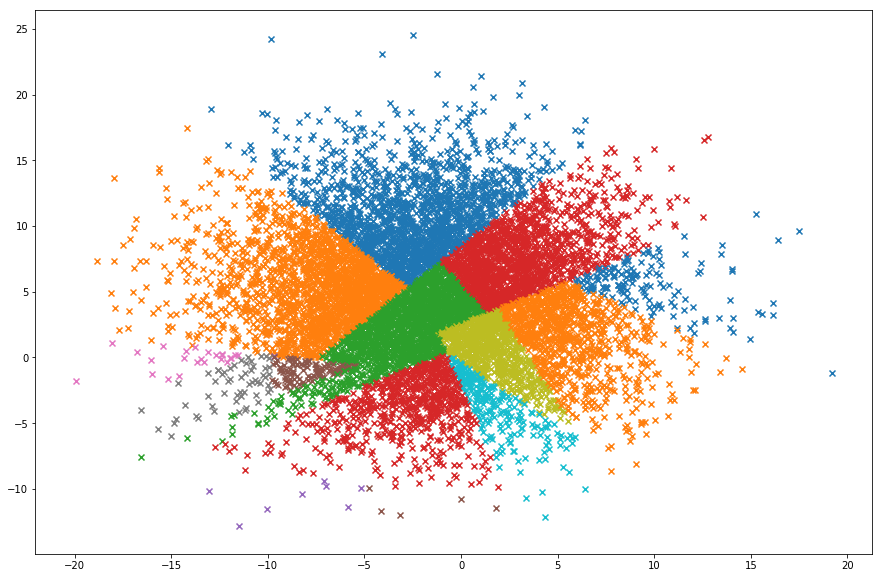

In [750]:
print('random projection tree (mean)')
tree = forest[0]
plt.figure(figsize=(15, 10))
stack = [tree['root']]
while len(stack) != 0:
    node = stack.pop()
    if 'idxs' not in node:
        stack.append(node['r'])
        stack.append(node['l'])
    else:
        plt.scatter(P[node['idxs'], 0], P[node['idxs'], 1], marker='x', alpha=1)

plt.show()

In [ ]:
def search_tree_max(tree, q):
    node = tree['root']
    while 'idxs' not in node:
        projection = q.dot(node['v'])
        if projection > node['split']:
            node = node['r']
        else:
            node = node['l']
            
    return node['idxs']

In [ ]:
def find_nearest_neighbors_max(forest, q):
    candidates = []
    for tree in forest:
        candidates.append(search_tree_max(tree, q))
    if len(candidates) != 0:
        candidates = np.unique(np.concatenate(np.array(candidates)))
    
    return candidates

#### Search

In [ ]:
%%time
q_idx = np.random.randint(10000)
print('find P[{}] nearest neighbors'.format(q_idx))
q = P[q_idx]
# candidates = search_tree(forest[0], q)
candidates = find_nearest_neighbors_max(forest, q)
print('number of candidates: {}'.format(len(candidates)))
plt.figure(figsize=(15, 10))
plt.scatter(P[:, 0], P[:, 1], marker='x')
plt.scatter(P[candidates, 0], P[candidates, 1], marker='x')
plt.scatter(q[0], q[1], c='r')
plt.show()

In [ ]:
class BiLevelIndex(object):
    def __init__(self, dataset):
        self.dataset_ = dataset
        self.n_, self.d_ = dataset.shape
        
    def build_forest(self, n_trees=10):
        pass
    
    def get_nns(self, query, k=1):
        pass
    
    def recall(self, test):
        pass
    
    def precision(self, test):
        pass
    
    def hashing_time(self, test):
        pass
    
    def query_time(self, test):
        pass
    
    def score(self, test):
        pass

### RP tree 3rd

In [ ]:
def rp_forest_3rd(P, n_trees=10, max_depth=None, min_size=None, random_state=None):
    """
    Desc:
        Now only support the leafs arg.
    
    Args:
        n_trees: number of trees
        depth:
        random_state
    
    Returns:
        split
        forest
        forest_leafs
        
    """
    assert max_depth is not None or min_size is not None, \
        "Should give one of the value of max_depth or min_size"

    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)
    
    c = 2
    forest = []
    n, d = P.shape
    s_idxs = []

    for i in range(n_trees):
        tree = dict()
        s_idxs.append((np.arange(n), tree, 'root', 0))

        while len(s_idxs) != 0:
            idxs, parent_node, direc, depth = s_idxs.pop()

            node = dict()

            if depth >= max_depth:
                node['idxs'] = idxs
                parent_node[direc] = node
                continue

            v = idxs[rand.choice(np.arange(len(idxs)), 2, replace=False)]
            v = P[v[1]] - P[v[0]]
            node['v'] = v

            diameter = compute_diamter(P[idxs])

            diameters = []
            select_idxs = idxs[rand.choice(np.arange(len(idxs)), 40, replace=False)]
            for idx in select_idxs:
                diameters.append(np.array([dis.euclidean(P[idx], p) for p in P[idxs]]).max())
            avg_diamters = diameters.mean()
            avg_2_diamters = avg_diamters ** 2
            
            diameter_2 = diameter ** 2
            print(diameter_2, avg_2_diamters)
            
            if diameter_2 <= c * avg_2_diamters:
                projection = P[idxs].dot(v)
                
            split = np.median(projection) + delta
            projection = P[idxs].dot(v)
            node['split'] = split            

            # print(projection)
            idxs_R = np.argwhere(projection > split)
            idxs_L = np.argwhere(projection <= split)
        
            # print(len(idxs_R), len(idxs_L))
            
            if len(idxs_R) != 0:
                R = idxs[np.concatenate(idxs_R)]
            if len(idxs_L) != 0:
                L = idxs[np.concatenate(idxs_L)]
            
            parent_node[direc] = node
            
            # print(direc)
            s_idxs.append((R, node, 'r', depth + 1))
            s_idxs.append((L, node, 'l', depth + 1))
            
        forest.append(tree)
        
    return forest

## Modeling LSH for Performan Tuning

$$
f_{\kappa, \theta}(x) = \alpha(\frac{x}{\theta})^\kappa e^{-x/\theta}
$$

$$
D = 2(\kappa + 1)
$$

E: 算术平均值  

G: 几何平均值

$$
\begin{cases}
\kappa \theta = E \\
\text{ln}(\kappa) - \psi(\kappa) = \text{ln}(E) - \text{ln}(G)   
\end{cases} \\
\psi(x) = \frac{\Gamma^{'}(x)}{\Gamma(x)}
$$

### For $X^2$

In [ ]:
def gmean(arr):
    return arr.prod() ** (1.0/len(arr))

In [ ]:
from scipy.spatial.distance import euclidean
from scipy.stats.mstats import gmean
from scipy.special import digamma
from scipy.stats import gamma

In [ ]:
n_select = 1000
idxs_select = np.random.choice(np.arange(10000), (n_select, 2), replace=False)
d_select = np.array([euclidean(P[idxs[0]], P[idxs[1]]) for idxs in idxs_select])

In [ ]:
E = (d_select**2).mean()
G = gmean(d_select**2)
print('E: {:.4f}, G: {:.4f}'.format(E, G))

In [ ]:
equation_right = np.log(E) - np.log(G)
Kappa = np.arange(1, 5, 0.5)
result = np.log(Kappa) - digamma(Kappa)
plt.plot(Kappa, result)
plt.xticks(Kappa)
plt.hlines(y=equation_right, xmin=Kappa[0], xmax=Kappa[-1])
plt.xlabel('kappa')
plt.ylabel('equation left')
plt.show()

In [ ]:
kappa = 1
theta = E / kappa
print('kappa: {}, theta: {:.4f}'.format(kappa, theta))

In [ ]:
ds = np.array([[euclidean(P[i], p) for p in P] for i in np.random.choice(np.arange(10000), 40)])

In [ ]:
ds = np.sort(ds)

In [ ]:
order_ds = ds.mean(axis=0)

In [ ]:
pp = np.linspace(gamma.ppf(0.01, a=kappa, scale=theta), gamma.ppf(0.99, a=kappa, scale=theta), 100)
pd = gamma.pdf(pp, a=kappa, scale=theta)

In [ ]:
plt.hist(order_ds**2, bins=100, density=True)
plt.plot(pp, pd)
plt.show()

### For $X_k^2$

$$
E[X_k] = \frac{[\Gamma(1+\frac{D_1}{2})]^{\frac{1}{D_1}}}{\sqrt \pi}(\frac{k}{N-1})^\frac{1}{D_2}
$$

$$
E_k = \alpha k^\beta N^\gamma \\
G_k = \alpha ^{'} k^{\beta'} N^{\gamma'}
$$

In [ ]:
n_anchors = 100
n = 10000
idxs_P = np.arange(n)
idxs_anchor = np.random.choice(np.arange(10000), n_anchors, replace=False)

idxs_rest = np.setdiff1d(idxs_P, idxs_anchor)

points_anchor = P[idxs_anchor]

In [ ]:
N = np.arange(1000, len(idxs_rest), 1000)
K = np.arange(50, 501, 50)

In [ ]:
idxs_samples = np.array([np.random.choice(np.arange(len(idxs_rest)), n, replace=False) for n in N])

In [ ]:
%%time
d_knns = []
for q in points_anchor:
    d_ns = []
    for idxs_sample in idxs_samples:
        d_ks = []
        ds = np.array([euclidean(q, p) for p in P[idxs_sample]])
        sort_ds = np.sort(ds)
        for k in K:
            d_ks.append(sort_ds[k])
        d_ns.append(d_ks)
    d_knns.append(d_ns)

In [ ]:
d_knns = np.array(d_knns)

In [ ]:
d_knns.shape

In [ ]:
d_1e4_knns = d_knns[:, -1, :]

In [ ]:
fix_n_1e4_mean = (d_1e4_knns ** 2).mean(axis=0)

In [ ]:
fix_n_1e4_gmean = (d_1e4_knns ** 2).prod(axis=0) ** (1 / n_anchors)

In [ ]:
plt.plot(K, fix_n_1e4_mean, label='mean', marker='x')
plt.plot(K, fix_n_1e4_gmean, label='gmean', marker='>')
plt.legend()
plt.show()

In [ ]:
nks = d_knns.mean(axis=0)

In [ ]:
nks

## Standard LSH

In [589]:
def compute_pr(w, c):
    """
    Args:
        w: 段长
        c: r1, r2, 距离
    """
    a = 2 * norm.cdf(-w/c)
    b = 2 / (np.sqrt(2 * np.pi) * w / c)
    d = np.e ** (-((w**2) / (2 * (c ** 2))))    
    return 1 - a - b * (1 - d)
    
def compute_rho(p1, p2):
    return (np.log(1/p1) / np.log(1/p2))

def compute_r1(P):
    d = P.shape[1]
    print('Estimate r1')
    print('P: {}'.format(P.shape))

#     n = P.shape[0] * 0.03
    n = 20
    nn = int(np.log(P.shape[0]))
    print('sample {} points, calculate near {} neighbors.'.format(n, nn))
    idx = np.random.choice(P.shape[0], size=n, replace=False)
    qs = P[idx]
    r1_avg = []
    for q in qs:
        dist_arr = np.array([dis.euclidean(q, p) for p in P])
        dist_sort = np.sort(dist_arr)
        avg = np.sort(dist_arr)[1:nn+1].mean()
        r1_avg.append(avg)

    r1 = np.array(r1_avg).mean()
    print('estimate r1 = {}'.format(r1))
    return r1

def draw_W(P, c=2):
    """
    Desc:
        绘制图像，观察最优 w 值
    Args:
        c: 近似因子
    """
    r1 = compute_r1(P)
    r2 = c * r1
    W = np.arange(r1 / 2, r1 * 10, r1 / 2)

    p1 = [compute_pr(w, r1) for w in W]
    p2 = [compute_pr(w, c * r1) for w in W]
    rho = [compute_rho(p1[i], p2[i]) for i in range(len(W))]

    plt.plot(W, p1, label='p1')
    plt.plot(W, p2, label='p2')
    plt.plot(W, rho, label='rho')
    plt.hlines(y=1/c, xmin=0, xmax=r1 * 10, label='1/c')
    plt.xlabel('w')
    plt.ylabel('p')
    plt.legend()
    plt.show()

In [1106]:
def generate_AB(d, M, W, L, random_state=None):
    """
    Args:
        d: dim
        M: same as k
        W: interval
        L: number of hash tables
    Returns:
        A: L * M * d
        B: L * M
    """
    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)
    A = rand.normal(0, 1, (L, M, d))
    B = rand.uniform(0, W, (L, M))
    return A, B

In [583]:
def hashing(v, a, b, W):
    return (a.dot(v) + b) / W

## $Z^8$

## Morton Curve

In [428]:
V = np.random.randint(0, 6, (10000, 8))

In [433]:
max_bit = len(bin(V.max())[2:])
max_bit

3

In [434]:
def morton_curve(v, max_bit):
    bin_codes = np.array([bin(i) for i in v])
    codes = []
    for i, code in enumerate(bin_codes):
        codes.append(code[2:])
        n = len(codes[i])
        for j in range(max_bit - n):
            codes[i] = '0' + codes[i]

    result = ''.join(np.array(list(map(list, codes))).T.reshape(1, -1)[0])
    return int(result, 2)

In [435]:
%%time
morton_numbers = [morton_curve(v, max_bit) for v in V]
morton_numbers.sort()

CPU times: user 339 ms, sys: 27.3 ms, total: 366 ms
Wall time: 330 ms


**四的倍数？如何判断相邻？**

## $E_8$ Lattice

In [ ]:
v = np.random.rand(8) + np.random.randint(0, 10, 8)

In [ ]:
v

In [ ]:
v1 = v.round()
v1

In [ ]:
v2 = (v - 1/2).round() + 1/2
v2

In [ ]:
dis.euclidean(v, v1), dis.euclidean(v, v2)

In [ ]:
# D8

## Multi Probe

## Experiment

### $Z^M$

In [584]:
L = [10, 20, 30]
M = 8
k = 50
n, d = train_sift.shape

#### Level 1

In [760]:
%%time
forest = rp_forest_normal(P=train_sift, max_depth=4)

CPU times: user 352 ms, sys: 6.63 ms, total: 358 ms
Wall time: 360 ms


random projection tree (mean)
15
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 276.76219929480243


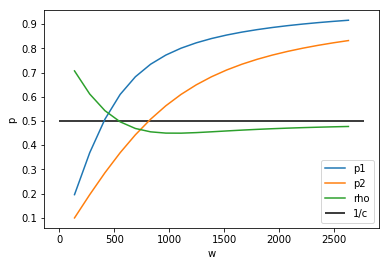

14
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 253.46181318239996


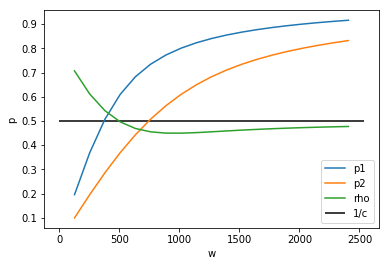

13
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 253.3547910701746


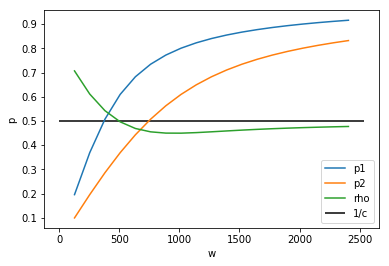

12
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 238.88331838007235


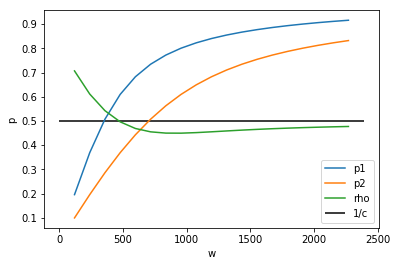

11
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 278.1601061863163


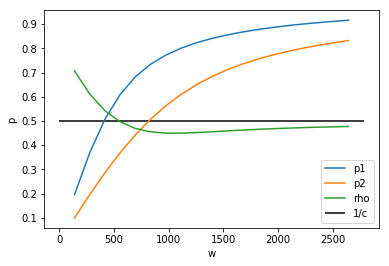

10
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 224.61516635277493


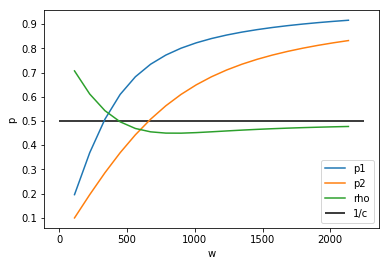

9
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 270.8951580139169


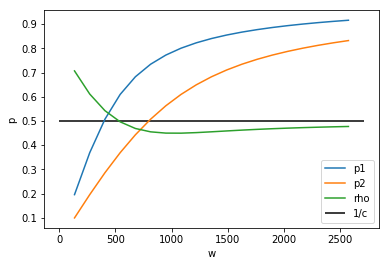

8
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 261.7784673395506


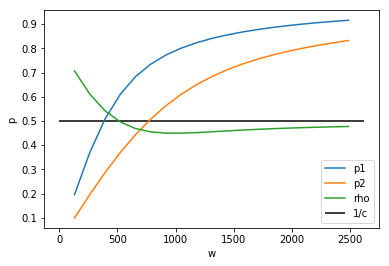

7
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 254.49636068368835


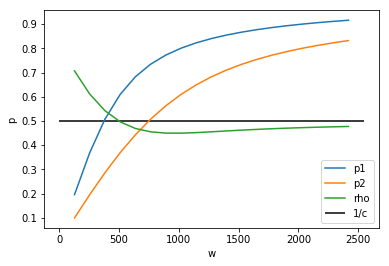

6
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 243.73109739003948


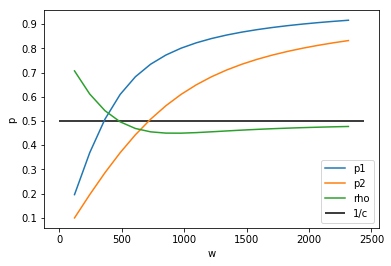

5
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 239.6223453689384


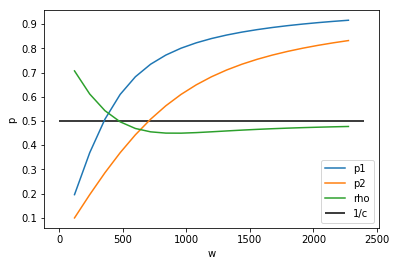

4
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 234.53942879047105


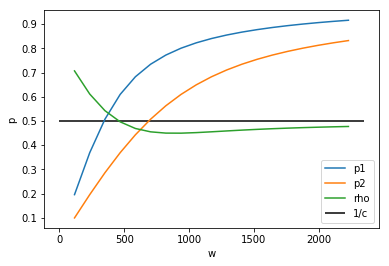

3
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 257.907481531378


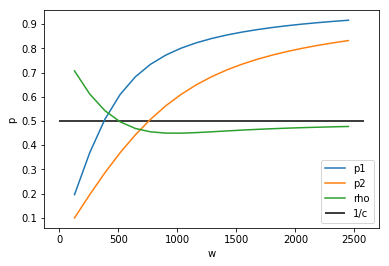

2
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 271.87202173807043


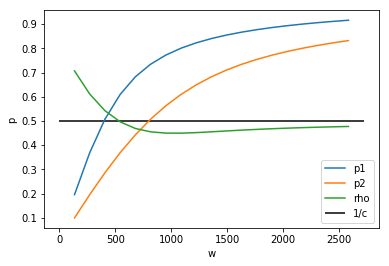

1
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 233.66967936847195


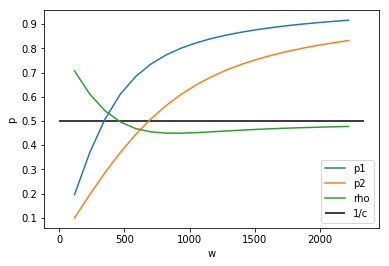

0
625
Estimate r1
P: (625, 128)
sample 20 points, calculate near 6 neighbors.
estimate r1 = 196.1060634856339


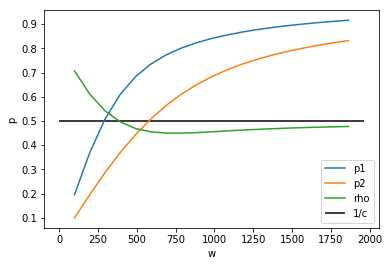

In [761]:
print('random projection tree (mean)')
tree = forest[0]
stack = [(tree['root'], '')]

while len(stack) != 0:
    node, code = stack.pop()
    if 'idxs' not in node:
        stack.append((node['r'], code + '0'))
        stack.append((node['l'], code + '1'))
    else:
        print(int(code, 2))
        print(len(node['idxs']))
        draw_W(train_sift[node['idxs']])
        idxs = node['idxs']

#### Level 2

generate A and B

Estimate r1
P: (10000, 128)
sample 20 points, calculate near 9 neighbors.
estimate r1 = 241.39940640421818


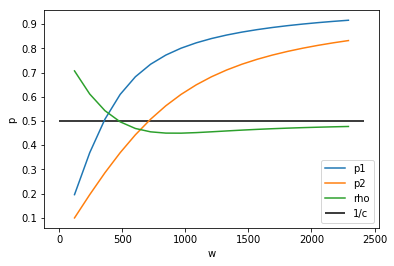

In [590]:
draw_W(train_sift)

In [898]:
W = np.arange(500, 2100, 100)
W

array([ 500,  600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500,
       1600, 1700, 1800, 1900, 2000])

In [855]:
A, B = generate_AB(d=d, L=L[0], M=M, W=W[-1])

In [856]:
print('Level 2: Store points into buckets')

def construct_tables(forest, P, A, B, L, W):
    trees = [] # n trees
    for tree in forest:
        nodes = dict() # 16 nodes
        stack = [tree['root']]
        while len(stack) != 0:
            node = stack.pop()
            if 'idxs' not in node:
                stack.append((node['r']))
                stack.append((node['l']))
            else:
                code = node['code']
                tables = [] # L buckets
                idxs = node['idxs']

                # Level 2
                for i in range(L):
                    buckets = dict() # n bucket
                    H = np.floor((P[idxs].dot(A[i].T) + B[i]) / W)
                    for j, h in enumerate(H):
                        bi = generate_md5(h)
                        if bi in buckets:
                            buckets[bi].append(idxs[j])
                        else:
                            buckets[bi] = [idxs[j]]
                    tables.append(buckets)

                nodes[code] = tables

        trees.append(nodes)

    return trees

Level 2: Store points into buckets


- trees: array, n 棵树
    - nodes: dict, 16 个叶子节点, key=code
        - tables: array, L 个哈希表
            - buckets: dict, m 个哈希桶, key=bucket_index

In [857]:
%%time
trees = construct_tables(forest, train_sift, A, B, L[0], W[-1])

CPU times: user 4min 26s, sys: 11 s, total: 4min 37s
Wall time: 2min 18s


#### Query

In [858]:
q = test_sift[0]

#### Find Tree Node Code

In [859]:
def find_leaf_codes(forest, q):
    leaf_codes = []
    for tree in forest:
        leaf_codes.append(search_tree_normal(tree, q))
    return leaf_codes

In [860]:
leaf_codes = find_leaf_codes(forest, q)
leaf_codes

[15, 5, 13, 0, 15, 2, 14, 9, 1, 0]

#### Candidates

In [861]:
def find_near_neighbors(trees, leaf_codes, q, A, B, L, W):
    result = []
    for i, code in enumerate(leaf_codes):
        tree = trees[i]
        node = tree[code]
        for j in range(L):
            h = np.floor((A[j].dot(q) + B[j]) / W)
            bi = generate_md5(h)
            if bi in node[j]:
                result.append(node[j][bi])
    return np.unique(np.concatenate(np.array(result)))

In [876]:
candidates = find_near_neighbors(trees, leaf_codes, q, A, B, L[0], W[-1]) 

#### Find k Nearest Neighbors

In [877]:
def find_k_nearest_neighbors(P, q, near_neighbors_idxs, K=50):
    if len(near_neighbors_idxs) < K:
        print('number of candidates less than K')
        print('K = number of candidates')
        K = len(near_neighbors_idxs)
    return near_neighbors_idxs[np.argsort(np.array(
        [dis.euclidean(q, p) for p in P[near_neighbors_idxs]])
                                         )[:K]
                              ]

In [879]:
approximate_neighbors = find_k_nearest_neighbors(train_sift, q, result)

#### Metrics

In [896]:
recall, error, s = metrics(candidates, 
                           approximate_neighbors, 
                           k_near_neighbors[dataset_title][0], 
                           q, train_sift)

print('recall = {:.4f}'.format(recall))
print('error  = {:.4f}'.format(error))
print('selevtivity = {:.4f}'.format(s))

recall = 0.5600
error  = 0.0195
selevtivity = 0.0454


#### Integration

In [1179]:
L = [10]
W =  np.arange(1500, 2100, 100)
M = 8
K = 50
n, d = train_sift.shape

In [1182]:
%%time

results = []

for l in L:
    for w in W:
        # 1. 构造 rp-tree
        forest = rp_forest_normal(P=train_sift, max_depth=4)
        # 2. 构造 hash table
        A, B = generate_AB(d=d, L=l, M=M, W=w)
        trees = construct_tables(forest, train_sift, A, B, l, w)
        
        result = dict()
        result['params'] = dict()
        result['params']['L'] = l
        result['params']['W'] = w
        
        print('L = {}, W = {}'.format(l, w))

        recall_arr = []
        error_arr = []
        selectivity_arr = []
        # 3. 查询点
        for i, q in enumerate(test_sift):
            leaf_codes = find_leaf_codes(forest, q)
            
            # 4. 获取 候选集 candidates
            candidates = find_near_neighbors(trees, leaf_codes, q, A, B, l, w) 

            # 5. 计算 近似 k近邻
            approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

            # 6. 评估
            recall, error, s = metrics(candidates, 
                           approximate_neighbors, 
                           k_near_neighbors[dataset_title][i], 
                           q, train_sift)
            
            recall_arr.append(recall)
            error_arr.append(error)
            selectivity_arr.append(s)
        result['metrics'] = dict()
        result['metrics']['recall'] = sum(recall_arr) / len(test_sift)
        result['metrics']['error'] = sum(error_arr) / len(test_sift)
        result['metrics']['selectivity'] = sum(selectivity_arr) / len(test_sift)
    
        metric_results['ZM'].append(result)
#         results.append(result)
    
# metric_results['ZM'] = results

L = 10, W = 1500
L = 10, W = 1600
L = 10, W = 1700
L = 10, W = 1800
L = 10, W = 1900
L = 10, W = 2000
CPU times: user 27min 47s, sys: 1min 7s, total: 28min 55s
Wall time: 14min 44s


In [1183]:
metric_results['ZM']

[{'params': {'L': 10, 'W': 800},
  'metrics': {'recall': 0.5114,
   'error': 0.9496986016386333,
   'selectivity': 0.05025500000000001}},
 {'params': {'L': 10, 'W': 900},
  'metrics': {'recall': 0.5936,
   'error': 0.9631481655924893,
   'selectivity': 0.07044299999999999}},
 {'params': {'L': 10, 'W': 1000},
  'metrics': {'recall': 0.7502000000000001,
   'error': 0.982285130032508,
   'selectivity': 0.10893600000000005}},
 {'params': {'L': 10, 'W': 1100},
  'metrics': {'recall': 0.7822000000000001,
   'error': 0.9842419127213549,
   'selectivity': 0.12639900000000004}},
 {'params': {'L': 10, 'W': 1200},
  'metrics': {'recall': 0.8761999999999999,
   'error': 0.9923527568394098,
   'selectivity': 0.18321500000000007}},
 {'params': {'L': 10, 'W': 1300},
  'metrics': {'recall': 0.8836000000000003,
   'error': 0.9930869266633913,
   'selectivity': 0.17710899999999996}},
 {'params': {'L': 10, 'W': 1400},
  'metrics': {'recall': 0.8919999999999995,
   'error': 0.9939514458603395,
   'selecti

In [991]:
l = 10
w = 800
# 1. 构造 rp 树
forest = rp_forest_normal(P=train_sift, max_depth=4)
# 2. 构造 hash table
A, B = generate_AB(d=d, L=l, M=M, W=w)
trees = construct_tables(forest, train_sift, A, B, l, w)

recall_arr = []
error_arr = []
selectivity_arr = []
# 3. 查询点
for i, q in enumerate(test_sift):
    leaf_codes = find_leaf_codes(forest, q)

    # 4. 获取 候选集 candidates
    candidates = find_near_neighbors(trees, leaf_codes, q, A, B, l, w) 

    # 5. 计算 近似 k近邻
    approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

    # 6. 评估
    recall, error, s = metrics(candidates, 
                   approximate_neighbors, 
                   k_near_neighbors[dataset_title][i], 
                   q, train_sift)

    recall_arr.append(recall)
    error_arr.append(error)
    selectivity_arr.append(s)

print('L = {}, W = {}'.format(l, w))
print('recall = {:.4f}'.format(sum(recall_arr) / len(test_sift)))
print('error  = {:.4f}'.format(sum(error_arr) / len(test_sift)))
print('selevtivity = {:.4f}'.format(sum(selectivity_arr) / len(test_sift)))

L = 10, W = 800
L = 10, W = 800
recall = 0.5040
error  = 0.9515
selevtivity = 0.0476


In [1240]:
recall_arr = []
error_arr = []
selectivity_arr = []
for result in metric_results['ZM']:
    selectivity_arr.append(result['metrics']['selectivity'])
    recall_arr.append(result['metrics']['recall'])
    error_arr.append(result['metrics']['error'])

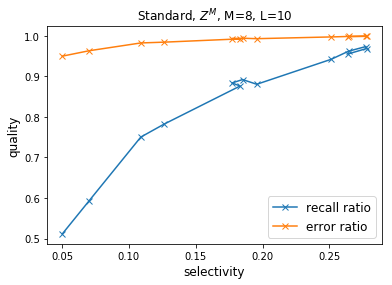

In [1241]:
plt.plot(selectivity_arr, recall_arr, marker='x', label='recall ratio')
plt.plot(selectivity_arr, error_arr, marker='x', label='error ratio')
plt.title('Standard, $Z^M$, M=8, L=10', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

### $E_8$

In [1102]:
def E8_decode(h, decode_type='E8'):
    D8 = h.round().astype(np.int)
    total = D8.sum()
    if total % 2 != 0:
        h2 = np.abs(np.modf(h)[0])
        h3 = h2.copy()
        # 排序
        h3[h3 < 0.5] = 0.5 - h3[h3 < 0.5]
        h3[h3 > 0.5] = h3[h3 > 0.5] - 0.5
        order = h3.argsort()

    i = 0
    while total % 2 != 0: # 或许没有必要？
        if h2[order[i]] > 0.5:
            D8[order[i]] -= 1
        else:
            D8[order[i]] += 1
        total = D8.sum()
        i += 1
    
    if decode_type == 'E8':
        D812 = E8_decode(h - 1/2, 'D8') + 1/2 # 递归求解 D8 + 1/2
        
        d1 = dis.euclidean(h, D8)
        d2 = dis.euclidean(h, D812)
        
        if d1 > d2:
            return D812
        else:
            return D8
    else:
        return D8

In [1103]:
E8 = E8_decode(h)
E8

array([ 0.5, -0.5,  0.5,  0.5,  1.5,  0.5,  0.5,  0.5])

In [1104]:
print('Level 2: Store points into buckets')

def construct_tables_E8(forest, P, A, B, L, W):
    trees = [] # n trees
    for tree in forest:
        nodes = dict() # 16 nodes
        stack = [tree['root']]
        while len(stack) != 0:
            node = stack.pop()
            if 'idxs' not in node:
                stack.append((node['r']))
                stack.append((node['l']))
            else:
                code = node['code']
                tables = [] # L buckets
                idxs = node['idxs']

                # Level 2
                for i in range(L):
                    E8 = dict() # n bucket
                    H = (P[idxs].dot(A[i].T) + B[i]) / W
                    
                    for j, h in enumerate(H):
                        E8_code = E8_decode(h)
                        bi = generate_md5(E8_code)
                        if bi in E8:
                            E8[bi].append(idxs[j])
                        else:
                            E8[bi] = [idxs[j]]
                    
                    tables.append(E8)

                nodes[code] = tables

        trees.append(nodes)

    return trees

Level 2: Store points into buckets


In [1105]:
def find_near_neighbors_E8(trees, leaf_codes, q, A, B, L, W, M):
    result = []
    for i, code in enumerate(leaf_codes):
        tree = trees[i]
        node = tree[code]
        for j in range(L):
            E8 = node[j] # morton curve
            h = (A[j].dot(q) + B[j]) / W
            E8_code = E8_decode(h)
            
            bi = generate_md5(E8_code)
            if bi in E8:
                result.append(E8[bi])
                
    return np.unique(np.concatenate(np.array(result)))

#### Integration

In [1207]:
L = [10]
W =  np.arange(1400, 2100, 100)
M = 8
K = 50
n, d = train_sift.shape

In [1204]:
metric_results['E8'] = []

In [1208]:
%%time

for l in L:
    for w in W:
        # 1. 构造 rp 树
        forest = rp_forest_normal(P=train_sift, max_depth=4)
        # 2. 构造 hash table
        A, B = generate_AB(d=d, L=l, M=M, W=w, random_state=1)

        trees = construct_tables_E8(forest, train_sift, A, B, l, w)
        
        result = dict()
        result['params'] = dict()
        result['params']['L'] = l
        result['params']['W'] = w
        
        print('L = {}, W = {}'.format(l, w))
        recall_arr = []
        error_arr = []
        selectivity_arr = []

        # 3. 查询点
        for i, q in enumerate(test_sift):
            leaf_codes = find_leaf_codes(forest, q)

            # 4. 获取 候选集 candidates multiprobe
            candidates = find_near_neighbors_E8(trees, leaf_codes, q, A, B, l, w, M) 

            # 5. 计算 近似 k近邻
            approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)
            
            # 6. 评估
            recall, error, s = metrics(candidates, 
                           approximate_neighbors, 
                           k_near_neighbors[dataset_title][i], 
                           q, train_sift)
            
            recall_arr.append(recall)
            error_arr.append(error)
            selectivity_arr.append(s)
            
        result['metrics'] = dict()
        result['metrics']['recall'] = sum(recall_arr) / len(test_sift)
        result['metrics']['error'] = sum(error_arr) / len(test_sift)
        result['metrics']['selectivity'] = sum(selectivity_arr) / len(test_sift)
    
        metric_results['E8'].append(result)

L = 10, W = 1400
L = 10, W = 1500
L = 10, W = 1600
L = 10, W = 1700
L = 10, W = 1800
L = 10, W = 1900
L = 10, W = 2000
CPU times: user 44min 45s, sys: 1min 54s, total: 46min 39s
Wall time: 23min 37s


In [1224]:
metric_results['E8']

[{'params': {'L': 10, 'W': 800},
  'metrics': {'recall': 0.5932000000000002,
   'error': 0.9623510536602609,
   'selectivity': 0.06093300000000002}},
 {'params': {'L': 10, 'W': 900},
  'metrics': {'recall': 0.6980000000000001,
   'error': 0.9763188757643756,
   'selectivity': 0.09419500000000003}},
 {'params': {'L': 10, 'W': 1000},
  'metrics': {'recall': 0.7909999999999999,
   'error': 0.9855044898487144,
   'selectivity': 0.12861100000000003}},
 {'params': {'L': 10, 'W': 1100},
  'metrics': {'recall': 0.8565999999999997,
   'error': 0.9910907949774357,
   'selectivity': 0.15597799999999995}},
 {'params': {'L': 10, 'W': 1200},
  'metrics': {'recall': 0.8912000000000002,
   'error': 0.99363055330331,
   'selectivity': 0.184015}},
 {'params': {'L': 10, 'W': 1300},
  'metrics': {'recall': 0.9174000000000002,
   'error': 0.9951972586605254,
   'selectivity': 0.21562799999999993}},
 {'params': {'L': 10, 'W': 1400},
  'metrics': {'recall': 0.9380000000000002,
   'error': 0.9965437236599506,

In [1222]:
recall_arr_E8 = []
error_arr_E8 = []
selectivity_arr_E8 = []
for result in metric_results['E8']:
    selectivity_arr_E8.append(result['metrics']['selectivity'])
    recall_arr_E8.append(result['metrics']['recall'])
    error_arr_E8.append(result['metrics']['error'])

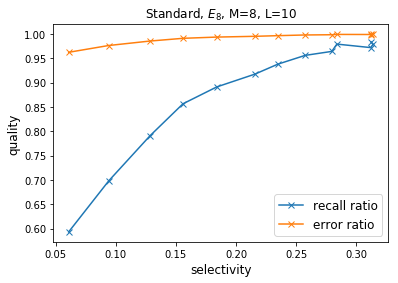

In [1225]:
plt.plot(selectivity_arr_E8, recall_arr_E8, marker='x', label='recall ratio')
plt.plot(selectivity_arr_E8, error_arr_E8, marker='x', label='error ratio')
plt.title('Standard, $E_8$, M=8, L=10', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [1107]:
l = 10
w = 1100
# 1. 构造 rp 树
forest = rp_forest_normal(P=train_sift, max_depth=4)
# 2. 构造 hash table
A, B = generate_AB(d=d, L=l, M=M, W=w, random_state=1)

trees = construct_tables_E8(forest, train_sift, A, B, l, w)

recall_arr = []
error_arr = []
selectivity_arr = []

# 3. 查询点
for i, q in enumerate(test_sift):
    leaf_codes = find_leaf_codes(forest, q)

    # 4. 获取 候选集 candidates multiprobe
    candidates = find_near_neighbors_E8(trees, leaf_codes, q, A, B, l, w, M) 

    # 5. 计算 近似 k近邻
    approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

    # 6. 评估
    recall, error, s = metrics(candidates, 
                   approximate_neighbors, 
                   k_near_neighbors[dataset_title][i], 
                   q, train_sift)

    recall_arr.append(recall)
    error_arr.append(error)
    selectivity_arr.append(s)

print('L = {}, W = {}'.format(l, w))
print('recall = {:.4f}'.format(sum(recall_arr) / len(test_sift)))
print('error  = {:.4f}'.format(sum(error_arr) / len(test_sift)))
print('selevtivity = {:.4f}'.format(sum(selectivity_arr) / len(test_sift)))

L = 10, W = 1100
recall = 0.8556
error  = 0.9912
selevtivity = 0.1573


### $Z^M$ multiprobe

$$
score(\pi_t) = \Sigma_{i=1}^M\Delta_i^2(\delta_{t,i}) \\
\Delta_i(\delta) = \delta \cdot[h_i+\frac{1}{2}(1 + \delta)-\frac{a_i\cdot v + b_i}{W}]
$$

In [954]:
def get_probe_order(q, a, b, W, M):
    real_h = (a.dot(q) + b) / W # 真实 hash 值
    h = np.floor(real_h)  # 向下取整
    positive = h - real_h + 1  # delta 取 1
    negative = -(h - real_h)  # delta 取 -1
    order = np.argsort(np.append(positive, negative)) # 排序
    sign = np.append(np.repeat(1, M), np.repeat(-1, M)) # 符号
    return order % M, sign[order]

In [957]:
get_probe_order(q, A[0], B[0], w, M)

(array([0, 7, 3, 5, 6, 4, 2, 1, 1, 2, 4, 6, 5, 3, 7, 0]),
 array([-1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1,  1]))

In [984]:
def find_near_neighbors_multiprobe(trees, leaf_codes, q, A, B, L, W, M, T=0):
    result = []
    for i, code in enumerate(leaf_codes):
        tree = trees[i]
        node = tree[code]
        for j in range(L):
            h = np.floor((A[j].dot(q) + B[j]) / W)
            bi = generate_md5(h)
            if bi in node[j]:
                result.append(node[j][bi])
            # probe
            t = 0
            current_pos = 0
            order, sign = get_probe_order(q, A[j], B[j], W, M)
            while t < T and current_pos < len(order):
                new_h = h.copy()
                new_h[order[current_pos]] += sign[current_pos]
                bi = generate_md5(new_h)
                if bi in node[j]:
                    result.append(node[j][bi])
                    t += 1
                current_pos += 1
                
    return np.unique(np.concatenate(np.array(result)))

#### Integration

In [1219]:
L = [10]
W =  np.arange(900, 2100, 100)
M = 8
K = 50
n, d = train_sift.shape

In [1211]:
metric_results['ZM_Multiprobe'] = []

In [1236]:
%%time

for l in L:
    for w in W:
        # 1. 构造 rp 树
        forest = rp_forest_normal(P=train_sift, max_depth=4)
        # 2. 构造 hash table
        A, B = generate_AB(d=d, L=l, M=M, W=w, random_state=1)

        trees = construct_tables(forest, train_sift, A, B, l, w)
        
        result = dict()
        result['params'] = dict()
        result['params']['L'] = l
        result['params']['W'] = w
        
        print('L = {}, W = {}'.format(l, w))
        recall_arr = []
        error_arr = []
        selectivity_arr = []

        # 3. 查询点
        for i, q in enumerate(test_sift):
            leaf_codes = find_leaf_codes(forest, q)

            # 4. 获取 候选集 candidates multiprobe
            candidates = find_near_neighbors_multiprobe(trees, leaf_codes, q, A, B, l, w, M, T=1) 

            # 5. 计算 近似 k近邻
            approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

            # 6. 评估
            recall, error, s = metrics(candidates, 
                           approximate_neighbors, 
                           k_near_neighbors[dataset_title][i], 
                           q, train_sift)

            recall_arr.append(recall)
            error_arr.append(error)
            selectivity_arr.append(s)
            
        result['metrics'] = dict()
        result['metrics']['recall'] = sum(recall_arr) / len(test_sift)
        result['metrics']['error'] = sum(error_arr) / len(test_sift)
        result['metrics']['selectivity'] = sum(selectivity_arr) / len(test_sift)
    
        metric_results['ZM_Multiprobe'].append(result)

KeyboardInterrupt: 

In [1237]:
recall_arr_ZM_Multiprobe = []
error_arr_ZM_Multiprobe = []
selectivity_arr_ZM_Multiprobe = []
for result in metric_results['ZM_Multiprobe']:
    selectivity_arr_ZM_Multiprobe.append(result['metrics']['selectivity'])
    recall_arr_ZM_Multiprobe.append(result['metrics']['recall'])
    error_arr_ZM_Multiprobe.append(result['metrics']['error'])

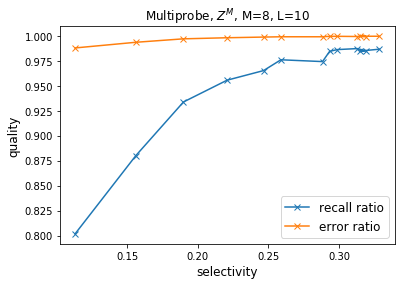

In [1238]:
plt.plot(selectivity_arr_ZM_Multiprobe, recall_arr_ZM_Multiprobe, marker='x', label='recall ratio')
plt.plot(selectivity_arr_ZM_Multiprobe, error_arr_ZM_Multiprobe, marker='x', label='error ratio')
plt.title('Multiprobe, $Z^M$, M=8, L=10', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [996]:
l = 10
w = 1100
# 1. 构造 rp 树
forest = rp_forest_normal(P=train_sift, max_depth=4)
# 2. 构造 hash table
A, B = generate_AB(d=d, L=l, M=M, W=w)
trees = construct_tables(forest, train_sift, A, B, l, w)

recall_arr = []
error_arr = []
selectivity_arr = []
# 3. 查询点
for i, q in enumerate(test_sift):
    leaf_codes = find_leaf_codes(forest, q)

    # 4. 获取 候选集 candidates multiprobe
    candidates = find_near_neighbors_multiprobe(trees, leaf_codes, q, A, B, l, w, M, T=1) 

    # 5. 计算 近似 k近邻
    approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

    # 6. 评估
    recall, error, s = metrics(candidates, 
                   approximate_neighbors, 
                   k_near_neighbors[dataset_title][i], 
                   q, train_sift)

    recall_arr.append(recall)
    error_arr.append(error)
    selectivity_arr.append(s)

print('L = {}, W = {}'.format(l, w))
print('recall = {:.4f}'.format(sum(recall_arr) / len(test_sift)))
print('error  = {:.4f}'.format(sum(error_arr) / len(test_sift)))
print('selevtivity = {:.4f}'.format(sum(selectivity_arr) / len(test_sift)))

L = 10, W = 1100
recall = 0.9488
error  = 0.9977
selevtivity = 0.2089


In [986]:
metric_results

{'ZM': [{'params': {'L': 10, 'W': 800},
   'metrics': {'recall': 0.5337999999999998,
    'error': 0.019032507163461252,
    'selectivity': 0.05282399999999999}},
  {'params': {'L': 10, 'W': 900},
   'metrics': {'recall': 0.6225999999999997,
    'error': 0.019366911699562287,
    'selectivity': 0.067073}},
  {'params': {'L': 10, 'W': 1000},
   'metrics': {'recall': 0.6987999999999995,
    'error': 0.01951953695998629,
    'selectivity': 0.09489}},
  {'params': {'L': 10, 'W': 1100},
   'metrics': {'recall': 0.8144,
    'error': 0.01974651781096109,
    'selectivity': 0.147666}},
  {'params': {'L': 10, 'W': 1200},
   'metrics': {'recall': 0.8520000000000003,
    'error': 0.01981496361430493,
    'selectivity': 0.16293999999999997}},
  {'params': {'L': 10, 'W': 1300},
   'metrics': {'recall': 0.88,
    'error': 0.01985191656100134,
    'selectivity': 0.17736799999999991}},
  {'params': {'L': 10, 'W': 1400},
   'metrics': {'recall': 0.9092,
    'error': 0.01989402757237892,
    'selectivity

### $E_8$ multiprobe

In [1160]:
import itertools
positions_1 = []
for i in itertools.combinations(range(8), 2):
    positions_1.append(i)

In [1161]:
signs = []
for i in itertools.product(range(-1, 2, 2), repeat=2):
    signs.append(i)

In [1162]:
type_1 = np.zeros((112, 8))

In [1163]:
i = 0
for position in positions:
    for sign in signs:
        type_1[i][position[0]] = sign[0]
        type_1[i][position[1]] = sign[1]
        i += 1

In [1165]:
type_2 = np.zeros((128, 8))

In [1166]:
type_2[:] = 0.5
type_2[1] = -0.5
type_2

array([[ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       ...,
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5]])

In [1167]:
positions_2 = []
for i in [2, 4, 6]:
    for j in itertools.combinations(range(8), i):
        positions_2.append(j)

In [1168]:
i = 2
for position in positions_2:
    for j in position:
        type_2[i][j] *= -1
    i += 1

In [1169]:
type_2

array([[ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5,  0.5, ...,  0.5,  0.5,  0.5],
       ...,
       [ 0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [ 0.5, -0.5,  0.5, ..., -0.5, -0.5, -0.5],
       [ 0.5,  0.5, -0.5, ..., -0.5, -0.5, -0.5]])

In [1170]:
# neighbors
# type_1, type_2

In [1175]:
def find_near_neighbors_E8_multiprobe(trees, leaf_codes, q, A, B, L, W, M, T=0):
    result = []
    for i, code in enumerate(leaf_codes):
        tree = trees[i]
        node = tree[code]
        for j in range(L):
            E8 = node[j] # morton curve
            h = (A[j].dot(q) + B[j]) / W
            E8_code = E8_decode(h)
            
            bi = generate_md5(E8_code)
            if bi in E8:
                result.append(E8[bi])
            
            # 112 neighbor
            neighbor_1 = type_1 + E8_code
            distance_1 = np.array([dis.euclidean(h, neighbor) for neighbor in neighbor_1])
            
            # 128 neighbor
            neighbor_2 = type_2 + E8_code
            distance_2 = np.array([dis.euclidean(h, neighbor) for neighbor in neighbor_2])
            
            distance = np.append(distance_1, distance_2)
            order = distance.argsort()
            
            t = 0
            i = 0
            while t < T and i < 240:
                if order[i] >= 112:
                    probe_h = neighbor_2[order[i] - 112]
                else:
                    probe_h = neighbor_1[order[i]]
                bi = generate_md5(probe_h)
                if bi in E8:
                    result.append(E8[bi])
                    t += 1
                i += 1
            
    return np.unique(np.concatenate(np.array(result)))

#### Integration

In [1213]:
L = [10]
W =  np.arange(800, 2100, 100)
M = 8
K = 50
n, d = train_sift.shape

In [1214]:
metric_results['E8_Multiprobe'] = []

In [1215]:
%%time

for l in L:
    for w in W:
        # 1. 构造 rp 树
        forest = rp_forest_normal(P=train_sift, max_depth=4)
        # 2. 构造 hash table
        A, B = generate_AB(d=d, L=l, M=M, W=w, random_state=1)

        trees = construct_tables_E8(forest, train_sift, A, B, l, w)
        
        result = dict()
        result['params'] = dict()
        result['params']['L'] = l
        result['params']['W'] = w
        
        print('L = {}, W = {}'.format(l, w))
        recall_arr = []
        error_arr = []
        selectivity_arr = []

        # 3. 查询点
        for i, q in enumerate(test_sift):
            leaf_codes = find_leaf_codes(forest, q)

            # 4. 获取 候选集 candidates multiprobe
            candidates = find_near_neighbors_E8_multiprobe(trees, leaf_codes, q, A, B, l, w, M, T=1) 

            # 5. 计算 近似 k近邻
            approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

            # 6. 评估
            recall, error, s = metrics(candidates, 
                           approximate_neighbors, 
                           k_near_neighbors[dataset_title][i], 
                           q, train_sift)

            recall_arr.append(recall)
            error_arr.append(error)
            selectivity_arr.append(s)
            
        result['metrics'] = dict()
        result['metrics']['recall'] = sum(recall_arr) / len(test_sift)
        result['metrics']['error'] = sum(error_arr) / len(test_sift)
        result['metrics']['selectivity'] = sum(selectivity_arr) / len(test_sift)
    
        metric_results['E8_Multiprobe'].append(result)

L = 10, W = 800
L = 10, W = 900
L = 10, W = 1000
L = 10, W = 1100
L = 10, W = 1200
L = 10, W = 1300
L = 10, W = 1400
L = 10, W = 1500
L = 10, W = 1600
L = 10, W = 1700
L = 10, W = 1800
L = 10, W = 1900
L = 10, W = 2000
CPU times: user 1h 31min 41s, sys: 3min 34s, total: 1h 35min 16s
Wall time: 52min


In [1246]:
recall_arr_E8_multiprobe = []
error_arr_E8_multiprobe = []
selectivity_arr_E8_multiprobe = []
for result in metric_results['E8_Multiprobe']:
    selectivity_arr_E8_multiprobe.append(result['metrics']['selectivity'])
    recall_arr_E8_multiprobe.append(result['metrics']['recall'])
    error_arr_E8_multiprobe.append(result['metrics']['error'])

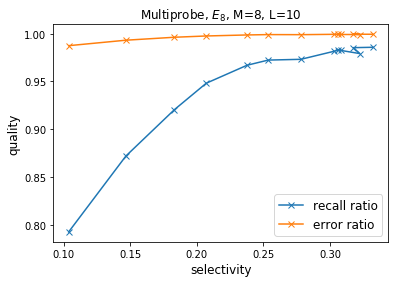

In [1247]:
plt.plot(selectivity_arr_E8_multiprobe, recall_arr_E8_multiprobe, marker='x', label='recall ratio')
plt.plot(selectivity_arr_E8_multiprobe, error_arr_E8_multiprobe, marker='x', label='error ratio')
plt.title('Multiprobe, $E_8$, M=8, L=10', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [1178]:
l = 10
w = 1100
# 1. 构造 rp 树
forest = rp_forest_normal(P=train_sift, max_depth=4)
# 2. 构造 hash table
A, B = generate_AB(d=d, L=l, M=M, W=w, random_state=1)

trees = construct_tables_E8(forest, train_sift, A, B, l, w)

recall_arr = []
error_arr = []
selectivity_arr = []

# 3. 查询点
for i, q in enumerate(test_sift):
    leaf_codes = find_leaf_codes(forest, q)

    # 4. 获取 候选集 candidates multiprobe
    candidates = find_near_neighbors_E8_multiprobe(trees, leaf_codes, q, A, B, l, w, M, T=1) 

    # 5. 计算 近似 k近邻
    approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

    # 6. 评估
    recall, error, s = metrics(candidates, 
                   approximate_neighbors, 
                   k_near_neighbors[dataset_title][i], 
                   q, train_sift)

    recall_arr.append(recall)
    error_arr.append(error)
    selectivity_arr.append(s)

print('L = {}, W = {}'.format(l, w))
print('recall = {:.4f}'.format(sum(recall_arr) / len(test_sift)))
print('error  = {:.4f}'.format(sum(error_arr) / len(test_sift)))
print('selevtivity = {:.4f}'.format(sum(selectivity_arr) / len(test_sift)))

L = 10, W = 1100
recall = 0.9524
error  = 0.9980
selevtivity = 0.2085


### hierarchical $Z^M$

#### Morton Curve

In [1230]:
print('Level 2: Store points into buckets')

def construct_tables_morton_curve(forest, P, A, B, L, W):
    trees = [] # n trees
    for tree in forest:
        nodes = dict() # 16 nodes
        stack = [tree['root']]
        while len(stack) != 0:
            node = stack.pop()
            if 'idxs' not in node:
                stack.append((node['r']))
                stack.append((node['l']))
            else:
                code = node['code']
                tables = [] # L buckets
                idxs = node['idxs']

                # Level 2
                for i in range(L):
                    curves = dict() # n bucket
                    H = np.floor((P[idxs].dot(A[i].T) + B[i]) / W)
                    
                    min_number = H.min()
                    if min_number < 0:
                        addition_number = -(H.min() - 1)
                    else:
                        addition_number = 0

                    curves['addition_number'] = addition_number
                    
                    H += addition_number
                    H = H.astype(np.int)
                    max_bit = len(bin(H.max())[2:])
                    curves['max_bit'] = max_bit
                    
                    morton_number = np.array([morton_curve(h, max_bit=max_bit) for h in H])
                    
                    buckets = dict()
                    
                    for j, number in enumerate(morton_number): # morton 唯一标识
                        if number in buckets:
                            buckets[number].append(idxs[j])
                        else:
                            buckets[number] = [idxs[j]]
                    
                    morton_number.sort()
                    curves['morton_number'] = morton_number # morton 码索引列表
                    curves['buckets'] = buckets
                    
                    tables.append(curves)

                nodes[code] = tables

        trees.append(nodes)

    return trees

Level 2: Store points into buckets


In [1231]:
def find_near_neighbors_morton(trees, leaf_codes, q, A, B, L, W, M, T=0):
    result = []
    for i, code in enumerate(leaf_codes):
        tree = trees[i]
        node = tree[code]
        for j in range(L):
            curve = node[j] # morton curve
            h = np.floor((A[j].dot(q) + B[j]) / W)
            h += curve['addition_number']
            h = h.astype(np.int)
            
            morton_number = morton_curve(h, curve['max_bit'])
            
            idx = np.argwhere(curve['morton_number'] < morton_number)
            if len(idx) == 0: # 最小
                idx = 0
            elif len(idx) == len(curve['morton_number']):
                idx = idx[-2][0]
            elif len(idx) == len(curve['morton_number']) - 1:
                idx = idx[-3][0]
            else:
                idx = idx[-1][0]

            m1 = curve['morton_number'][idx]            
            # print(idx)
            if morton_number in curve['buckets']:
                result.append(curve['buckets'][morton_number])
                m2 = curve['morton_number'][idx + 2]
            else:
                m2 = curve['morton_number'][idx + 1]
            
            # probe
            t = 0
            result.append(curve['buckets'][m1])
            result.append(curve['buckets'][m2])
                
    return np.unique(np.concatenate(np.array(result)))

#### Integration

In [1228]:
L = [10]
W =  np.arange(800, 2100, 100)
M = 8
K = 50
n, d = train_sift.shape

In [1217]:
metric_results['ZM_hierarchical'] = []

In [1232]:
%%time

for l in L:
    for w in W:
        # 1. 构造 rp 树
        forest = rp_forest_normal(P=train_sift, max_depth=4)
        # 2. 构造 hash table
        A, B = generate_AB(d=d, L=l, M=M, W=w, random_state=1)

        trees = construct_tables_morton_curve(forest, train_sift, A, B, l, w)
        
        result = dict()
        result['params'] = dict()
        result['params']['L'] = l
        result['params']['W'] = w
        
        print('L = {}, W = {}'.format(l, w))
        recall_arr = []
        error_arr = []
        selectivity_arr = []

        # 3. 查询点
        for i, q in enumerate(test_sift):
            leaf_codes = find_leaf_codes(forest, q)

            # 4. 获取 候选集 candidates multiprobe
            candidates = find_near_neighbors_morton(trees, leaf_codes, q, A, B, l, w, M, T=1) 

            # 5. 计算 近似 k近邻
            approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

            # 6. 评估
            recall, error, s = metrics(candidates, 
                           approximate_neighbors, 
                           k_near_neighbors[dataset_title][i], 
                           q, train_sift)

            recall_arr.append(recall)
            error_arr.append(error)
            selectivity_arr.append(s)

        result['metrics'] = dict()
        result['metrics']['recall'] = sum(recall_arr) / len(test_sift)
        result['metrics']['error'] = sum(error_arr) / len(test_sift)
        result['metrics']['selectivity'] = sum(selectivity_arr) / len(test_sift)
    
        metric_results['ZM_hierarchical'].append(result)

L = 10, W = 800
L = 10, W = 900
L = 10, W = 1000
L = 10, W = 1100
L = 10, W = 1200
L = 10, W = 1300
L = 10, W = 1400
L = 10, W = 1500
L = 10, W = 1600
L = 10, W = 1700
L = 10, W = 1800
L = 10, W = 1900
L = 10, W = 2000
CPU times: user 13min 50s, sys: 32 s, total: 14min 22s
Wall time: 7min 39s


In [1233]:
recall_arr_ZM_hierarchical = []
error_arr_ZM_hierarchical = []
selectivity_arr_ZM_hierarchical = []
for result in metric_results['ZM_hierarchical']:
    selectivity_arr_ZM_hierarchical.append(result['metrics']['selectivity'])
    recall_arr_ZM_hierarchical.append(result['metrics']['recall'])
    error_arr_ZM_hierarchical.append(result['metrics']['error'])

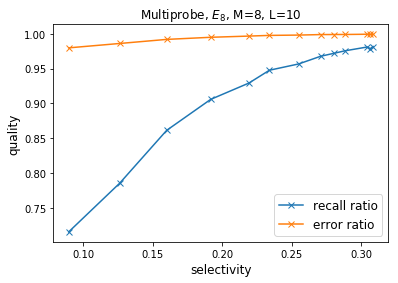

In [1234]:
plt.plot(selectivity_arr_ZM_hierarchical, recall_arr_ZM_hierarchical, marker='x', label='recall ratio')
plt.plot(selectivity_arr_ZM_hierarchical, error_arr_ZM_hierarchical, marker='x', label='error ratio')
plt.title('Multiprobe, $E_8$, M=8, L=10', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [1039]:
l = 10
w = 1100
# 1. 构造 rp 树
forest = rp_forest_normal(P=train_sift, max_depth=4)
# 2. 构造 hash table
A, B = generate_AB(d=d, L=l, M=M, W=w)
trees = construct_tables_morton_curve(forest, train_sift, A, B, l, w)

recall_arr = []
error_arr = []
selectivity_arr = []
# 3. 查询点
for i, q in enumerate(test_sift):
    leaf_codes = find_leaf_codes(forest, q)

    # 4. 获取 候选集 candidates multiprobe
    candidates = find_near_neighbors_morton(trees, leaf_codes, q, A, B, l, w, M, T=1) 

    # 5. 计算 近似 k近邻
    approximate_neighbors = find_k_nearest_neighbors(train_sift, q, candidates)

    # 6. 评估
    recall, error, s = metrics(candidates, 
                   approximate_neighbors, 
                   k_near_neighbors[dataset_title][i], 
                   q, train_sift)

    recall_arr.append(recall)
    error_arr.append(error)
    selectivity_arr.append(s)

print('L = {}, W = {}'.format(l, w))
print('recall = {:.4f}'.format(sum(recall_arr) / len(test_sift)))
print('error  = {:.4f}'.format(sum(error_arr) / len(test_sift)))
print('selevtivity = {:.4f}'.format(sum(selectivity_arr) / len(test_sift)))

L = 10, W = 1100
recall = 0.8730
error  = 0.9929
selevtivity = 0.1684


### hierarchical $E_8$

In [ ]:
def hierarchical_E8(E8_codes):
    E8_codes_unique = np.unique(E8_codes, axis=0)
    
    temp = E8_codes_unique.copy()
    m = 0
    temp_levels = []
    while len(temp) != 1:
        m += 1
        temp /= 2
        temp = np.array([E8_decode(code) for code in temp])
        temp = np.unique(temp, axis=0)
        
        current_temp = temp * (2 ** m) # current level HE8 code
        temp_levels.append(np.array([generate_md5(code) for code in current_temp]))

    print(m)

    temp_levels = np.array(temp_levels)

    levels = dict()
    node = dict()
    node['code'] = temp_levels[-1][0]
    levels['root'] = node
    
    

In [ ]:
print('Level 2: Store points into buckets')

def construct_tables_E8_hierarchical(forest, P, A, B, L, W):
    trees = [] # n trees
    for tree in forest:
        nodes = dict() # 16 nodes
        stack = [tree['root']]
        while len(stack) != 0:
            node = stack.pop()
            if 'idxs' not in node:
                stack.append((node['r']))
                stack.append((node['l']))
            else:
                code = node['code']
                tables = [] # L buckets
                idxs = node['idxs']

                # Level 2
                for i in range(L):
                    E8 = dict() # n bucket
                    E8_codes = []
                    H = (P[idxs].dot(A[i].T) + B[i]) / W
                    
                    for j, h in enumerate(H):
                        E8_code = E8_decode(h)
                        E8_codes.append(E8_code)
                        bi = generate_md5(E8_code)
                        if bi in E8:
                            E8[bi].append(idxs[j])
                        else:
                            E8[bi] = [idxs[j]]
                    level_E8 = hierarchical_E8(E8_codes)
                    tables.append(E8)

                nodes[code] = tables

        trees.append(nodes)

    return trees

### Integration

In [1242]:
len(recall_arr)

13

In [1245]:
x = np.linspace(0.02, 0.8, 13)

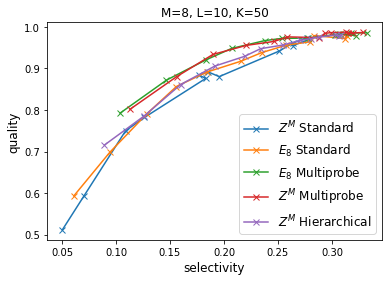

In [1249]:
plt.plot(selectivity_arr, recall_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_E8, recall_arr_E8, marker='x', label='$E_8$ Standard')
plt.plot(selectivity_arr_E8_multiprobe, recall_arr_E8_multiprobe, marker='x', label='$E_8$ Multiprobe')
plt.plot(selectivity_arr_ZM_Multiprobe, recall_arr_ZM_Multiprobe, marker='x', label='$Z^M$ Multiprobe')
plt.plot(selectivity_arr_ZM_hierarchical, recall_arr_ZM_hierarchical, marker='x', label='$Z^M$ Hierarchical')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

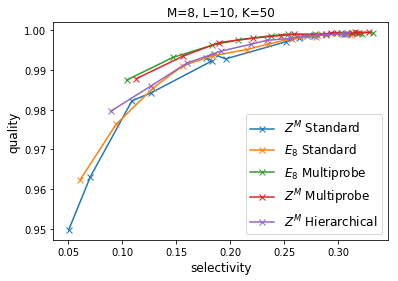

In [1250]:
plt.plot(selectivity_arr, error_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_E8, error_arr_E8, marker='x', label='$E_8$ Standard')
plt.plot(selectivity_arr_E8_multiprobe, error_arr_E8_multiprobe, marker='x', label='$E_8$ Multiprobe')
plt.plot(selectivity_arr_ZM_Multiprobe, error_arr_ZM_Multiprobe, marker='x', label='$Z^M$ Multiprobe')
plt.plot(selectivity_arr_ZM_hierarchical, error_arr_ZM_hierarchical, marker='x', label='$Z^M$ Hierarchical')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

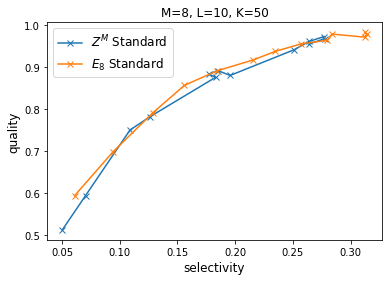

In [1251]:
plt.plot(selectivity_arr, recall_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_E8, recall_arr_E8, marker='x', label='$E_8$ Standard')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

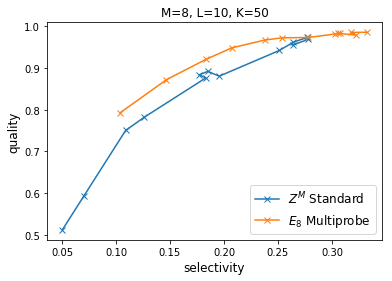

In [1252]:
plt.plot(selectivity_arr, recall_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_E8_multiprobe, recall_arr_E8_multiprobe, marker='x', label='$E_8$ Multiprobe')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

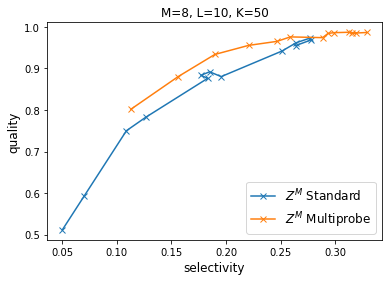

In [1253]:
plt.plot(selectivity_arr, recall_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_ZM_Multiprobe, recall_arr_ZM_Multiprobe, marker='x', label='$Z^M$ Multiprobe')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

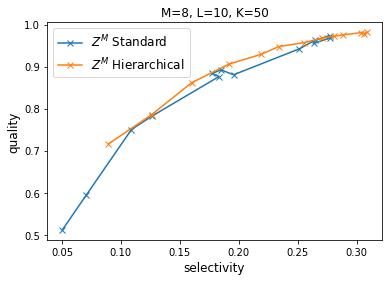

In [1254]:
plt.plot(selectivity_arr, recall_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_ZM_hierarchical, recall_arr_ZM_hierarchical, marker='x', label='$Z^M$ Hierarchical')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

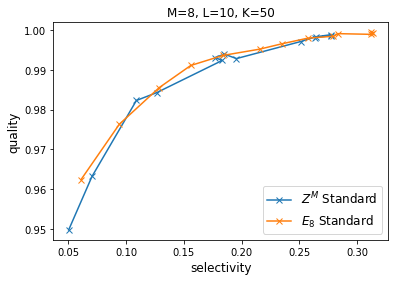

In [1255]:
plt.plot(selectivity_arr, error_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_E8, error_arr_E8, marker='x', label='$E_8$ Standard')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

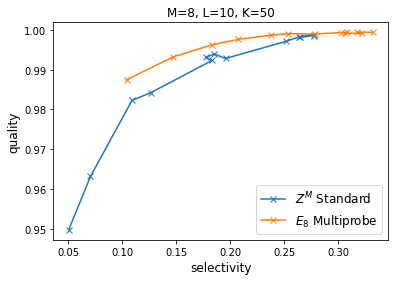

In [1256]:
plt.plot(selectivity_arr, error_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_E8_multiprobe, error_arr_E8_multiprobe, marker='x', label='$E_8$ Multiprobe')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

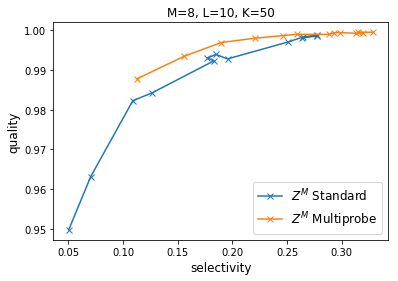

In [1257]:
plt.plot(selectivity_arr, error_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_ZM_Multiprobe, error_arr_ZM_Multiprobe, marker='x', label='$Z^M$ Multiprobe')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()

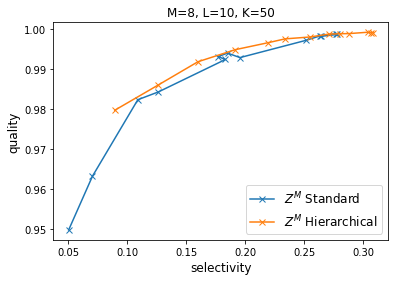

In [1258]:
plt.plot(selectivity_arr, error_arr, marker='x', label='$Z^M$ Standard')
plt.plot(selectivity_arr_ZM_hierarchical, error_arr_ZM_hierarchical, marker='x', label='$Z^M$ Hierarchical')
plt.title('M=8, L=10, K=50', fontsize=12)
plt.xlabel('selectivity', fontsize=12)
plt.ylabel('quality', fontsize=12)
plt.legend(fontsize=12)
plt.show()